## Settings

In [1]:
import os
from os.path import join as osj
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import numpy as np
import json
from workoutdetector.datasets import RepcountHelper
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.autolayout'] = True
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 0.8
COLORS = list(plt.get_cmap('Set3').colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', COLORS)
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300
helper = RepcountHelper('../data/RepCount/', os.path.expanduser('~/data/RepCount/annotation.csv'))
info = helper.get_rep_data(['test'], action=['all'])
CLASSES = helper.classes
print(CLASSES)
from workoutdetector.utils.inference_count import pred_to_count, write_to_video
from workoutdetector.utils import plot_all, plot_per_action, plot_pred, plt_params
plt.rcParams.update(plt_params())

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


## Count

In [2]:
video_save_dir = '../out/acc_0.841_epoch_26_20220711-191616_1x1'
video_json = os.listdir(video_save_dir)
print(video_json[0])
valtest = helper.get_rep_data(['val', 'test'], action=['all']).values()
video_iter = iter(video_json)

stu7_51.mp4.stride_1_step_1.json


In [3]:
json_path = next(video_iter)
js = json.load(open(osj(video_save_dir, json_path)))
gt = np.array(js['ground_truth'])
cls_idx = CLASSES.index(js['action'])
score = js['scores']
score_arr = np.array([list(d.values()) for d in score.values()])
softmax_score_arr = np.exp(score_arr) / np.sum(np.exp(score_arr), axis=1, keepdims=True)
threshold = 0.5
print(js['video_name'], js['action'])
print('count =', len(gt)//2)

/home/user/data/RepCount/videos/train/stu7_51.mp4 push_up
count = 47


In [4]:
print(js['video_name'], js['action'])
print(js['ground_truth'])

/home/user/data/RepCount/videos/train/stu7_51.mp4 push_up
[63, 85, 87, 103, 104, 120, 121, 135, 135, 151, 152, 166, 167, 183, 183, 199, 200, 213, 214, 229, 229, 244, 244, 258, 259, 273, 273, 289, 290, 305, 306, 319, 320, 335, 336, 350, 350, 365, 366, 380, 380, 395, 396, 410, 410, 424, 424, 441, 441, 455, 456, 470, 470, 484, 484, 499, 499, 514, 515, 530, 531, 545, 545, 560, 561, 577, 578, 592, 593, 607, 607, 622, 623, 636, 636, 652, 652, 667, 667, 683, 684, 697, 698, 713, 713, 728, 729, 744, 744, 759, 759, 774, 774, 791]


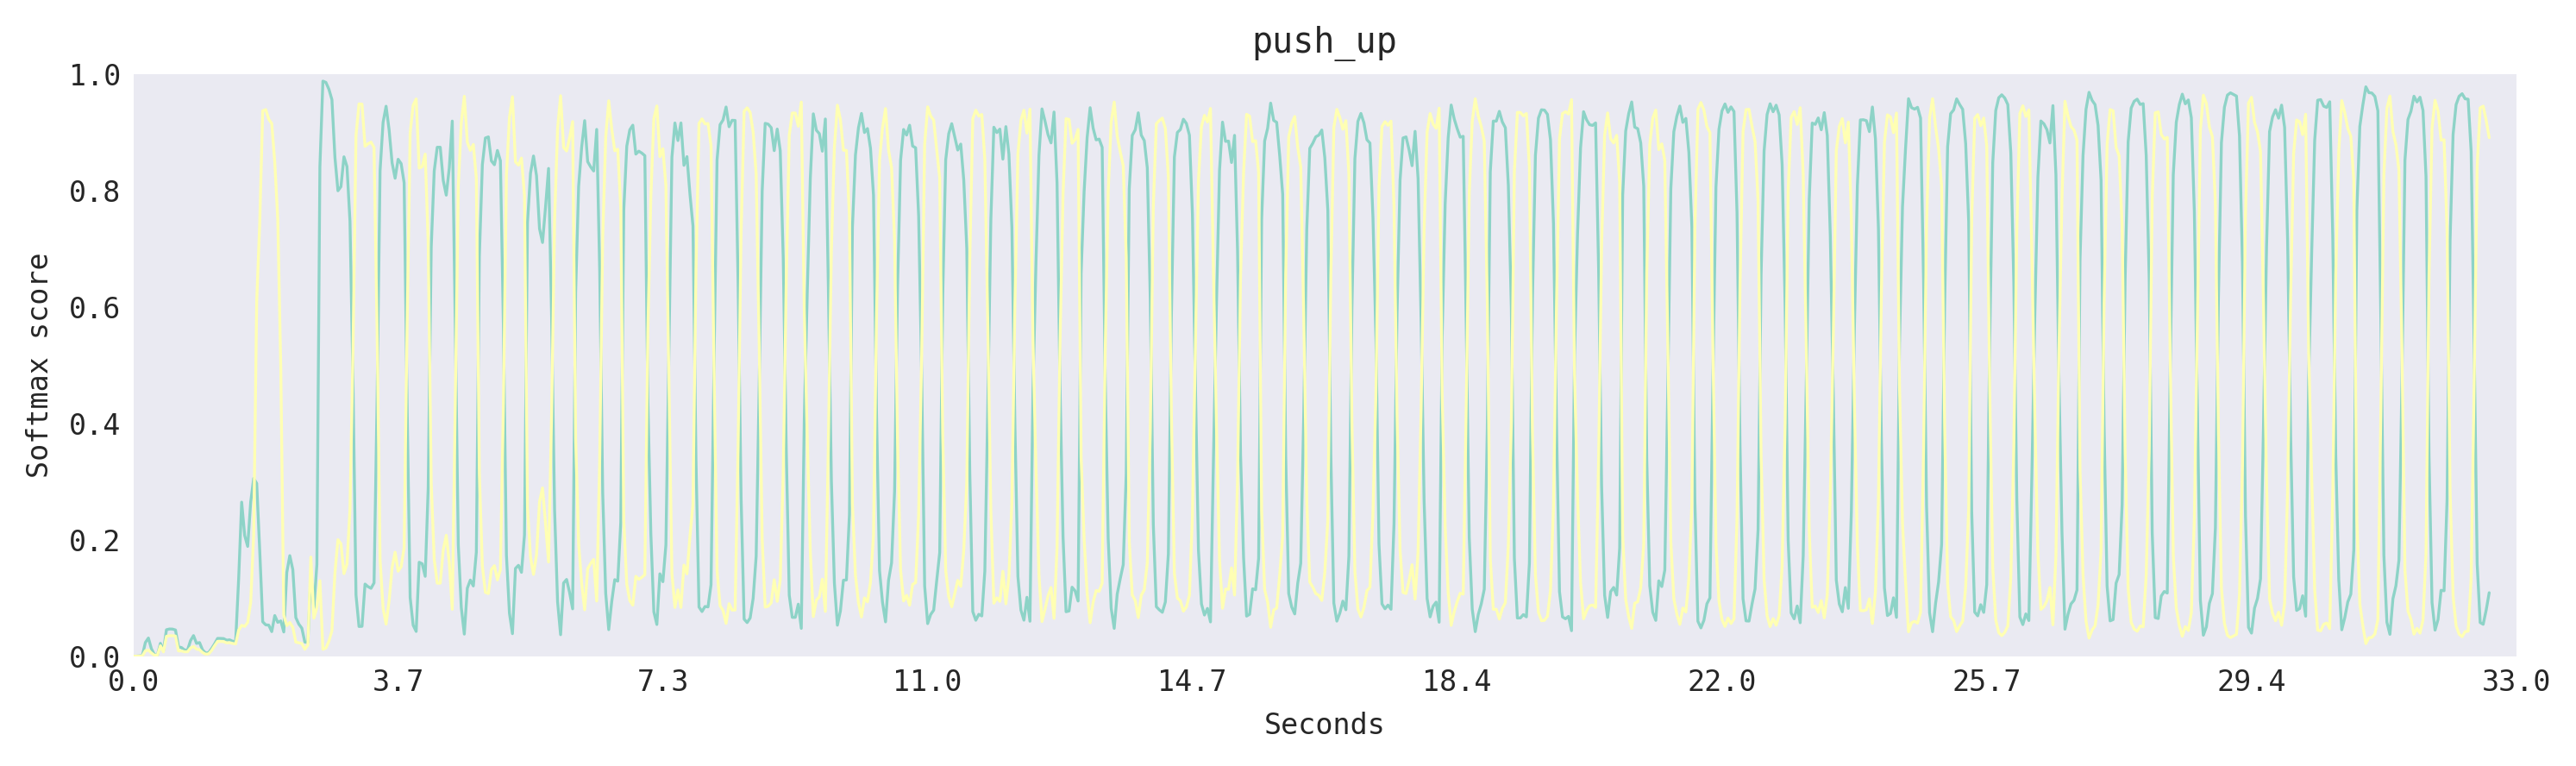

In [5]:
plot_per_action(js, softmax=True, action_only=True)

## Plot predictions

/home/user/data/RepCount/videos/train/train3312.mp4
[0, 16, 64, 80, 88, 96, 128, 136, 144, 160, 184, 208, 224, 232]
gt=4, pred=7
Absolute diff 3


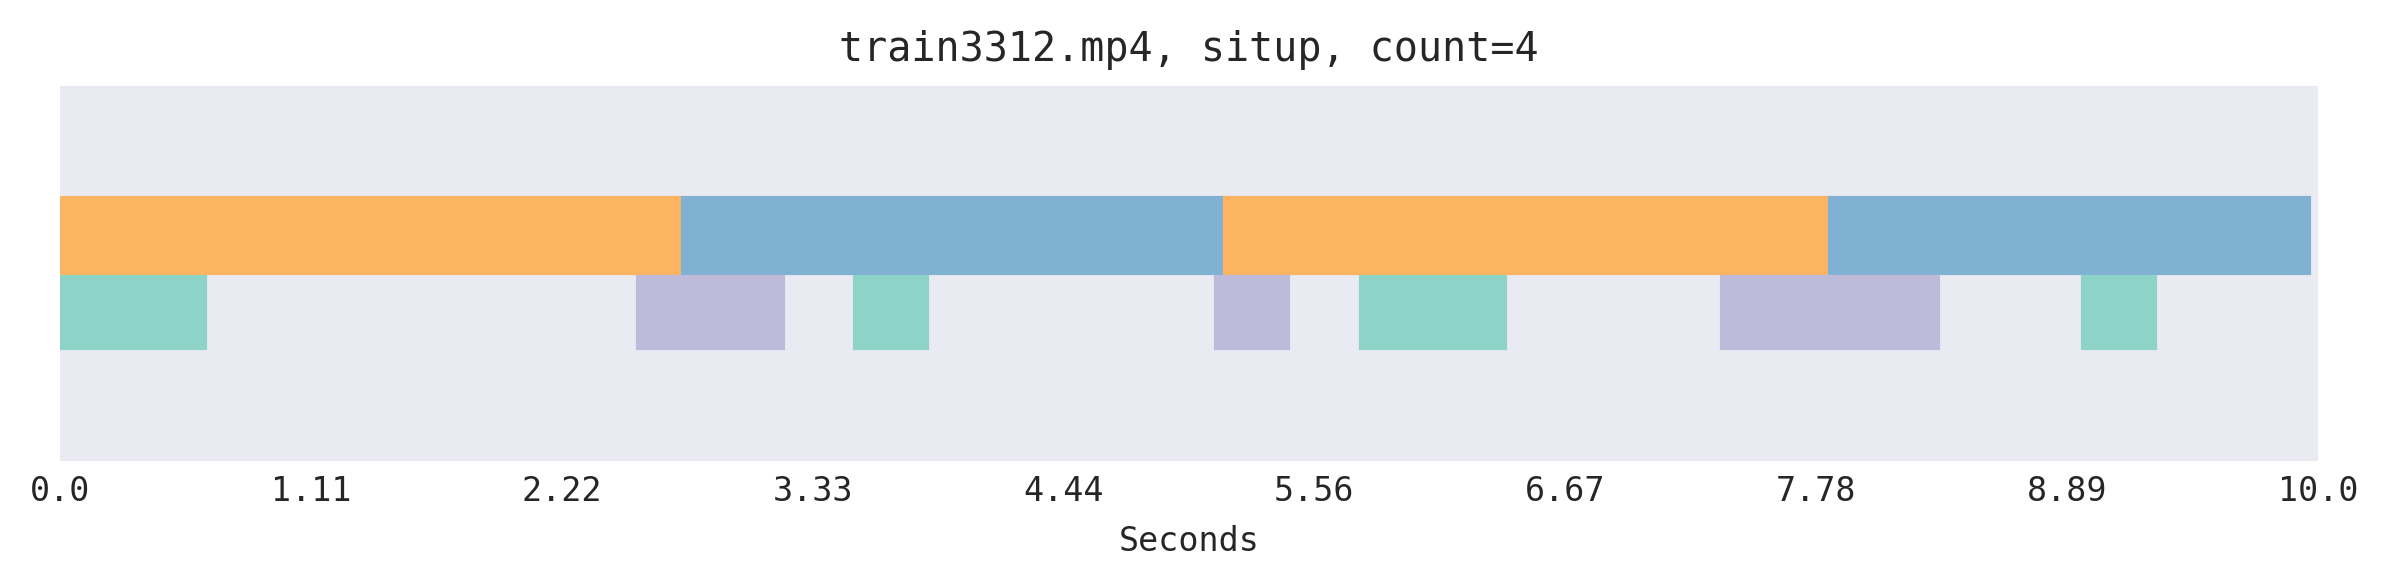

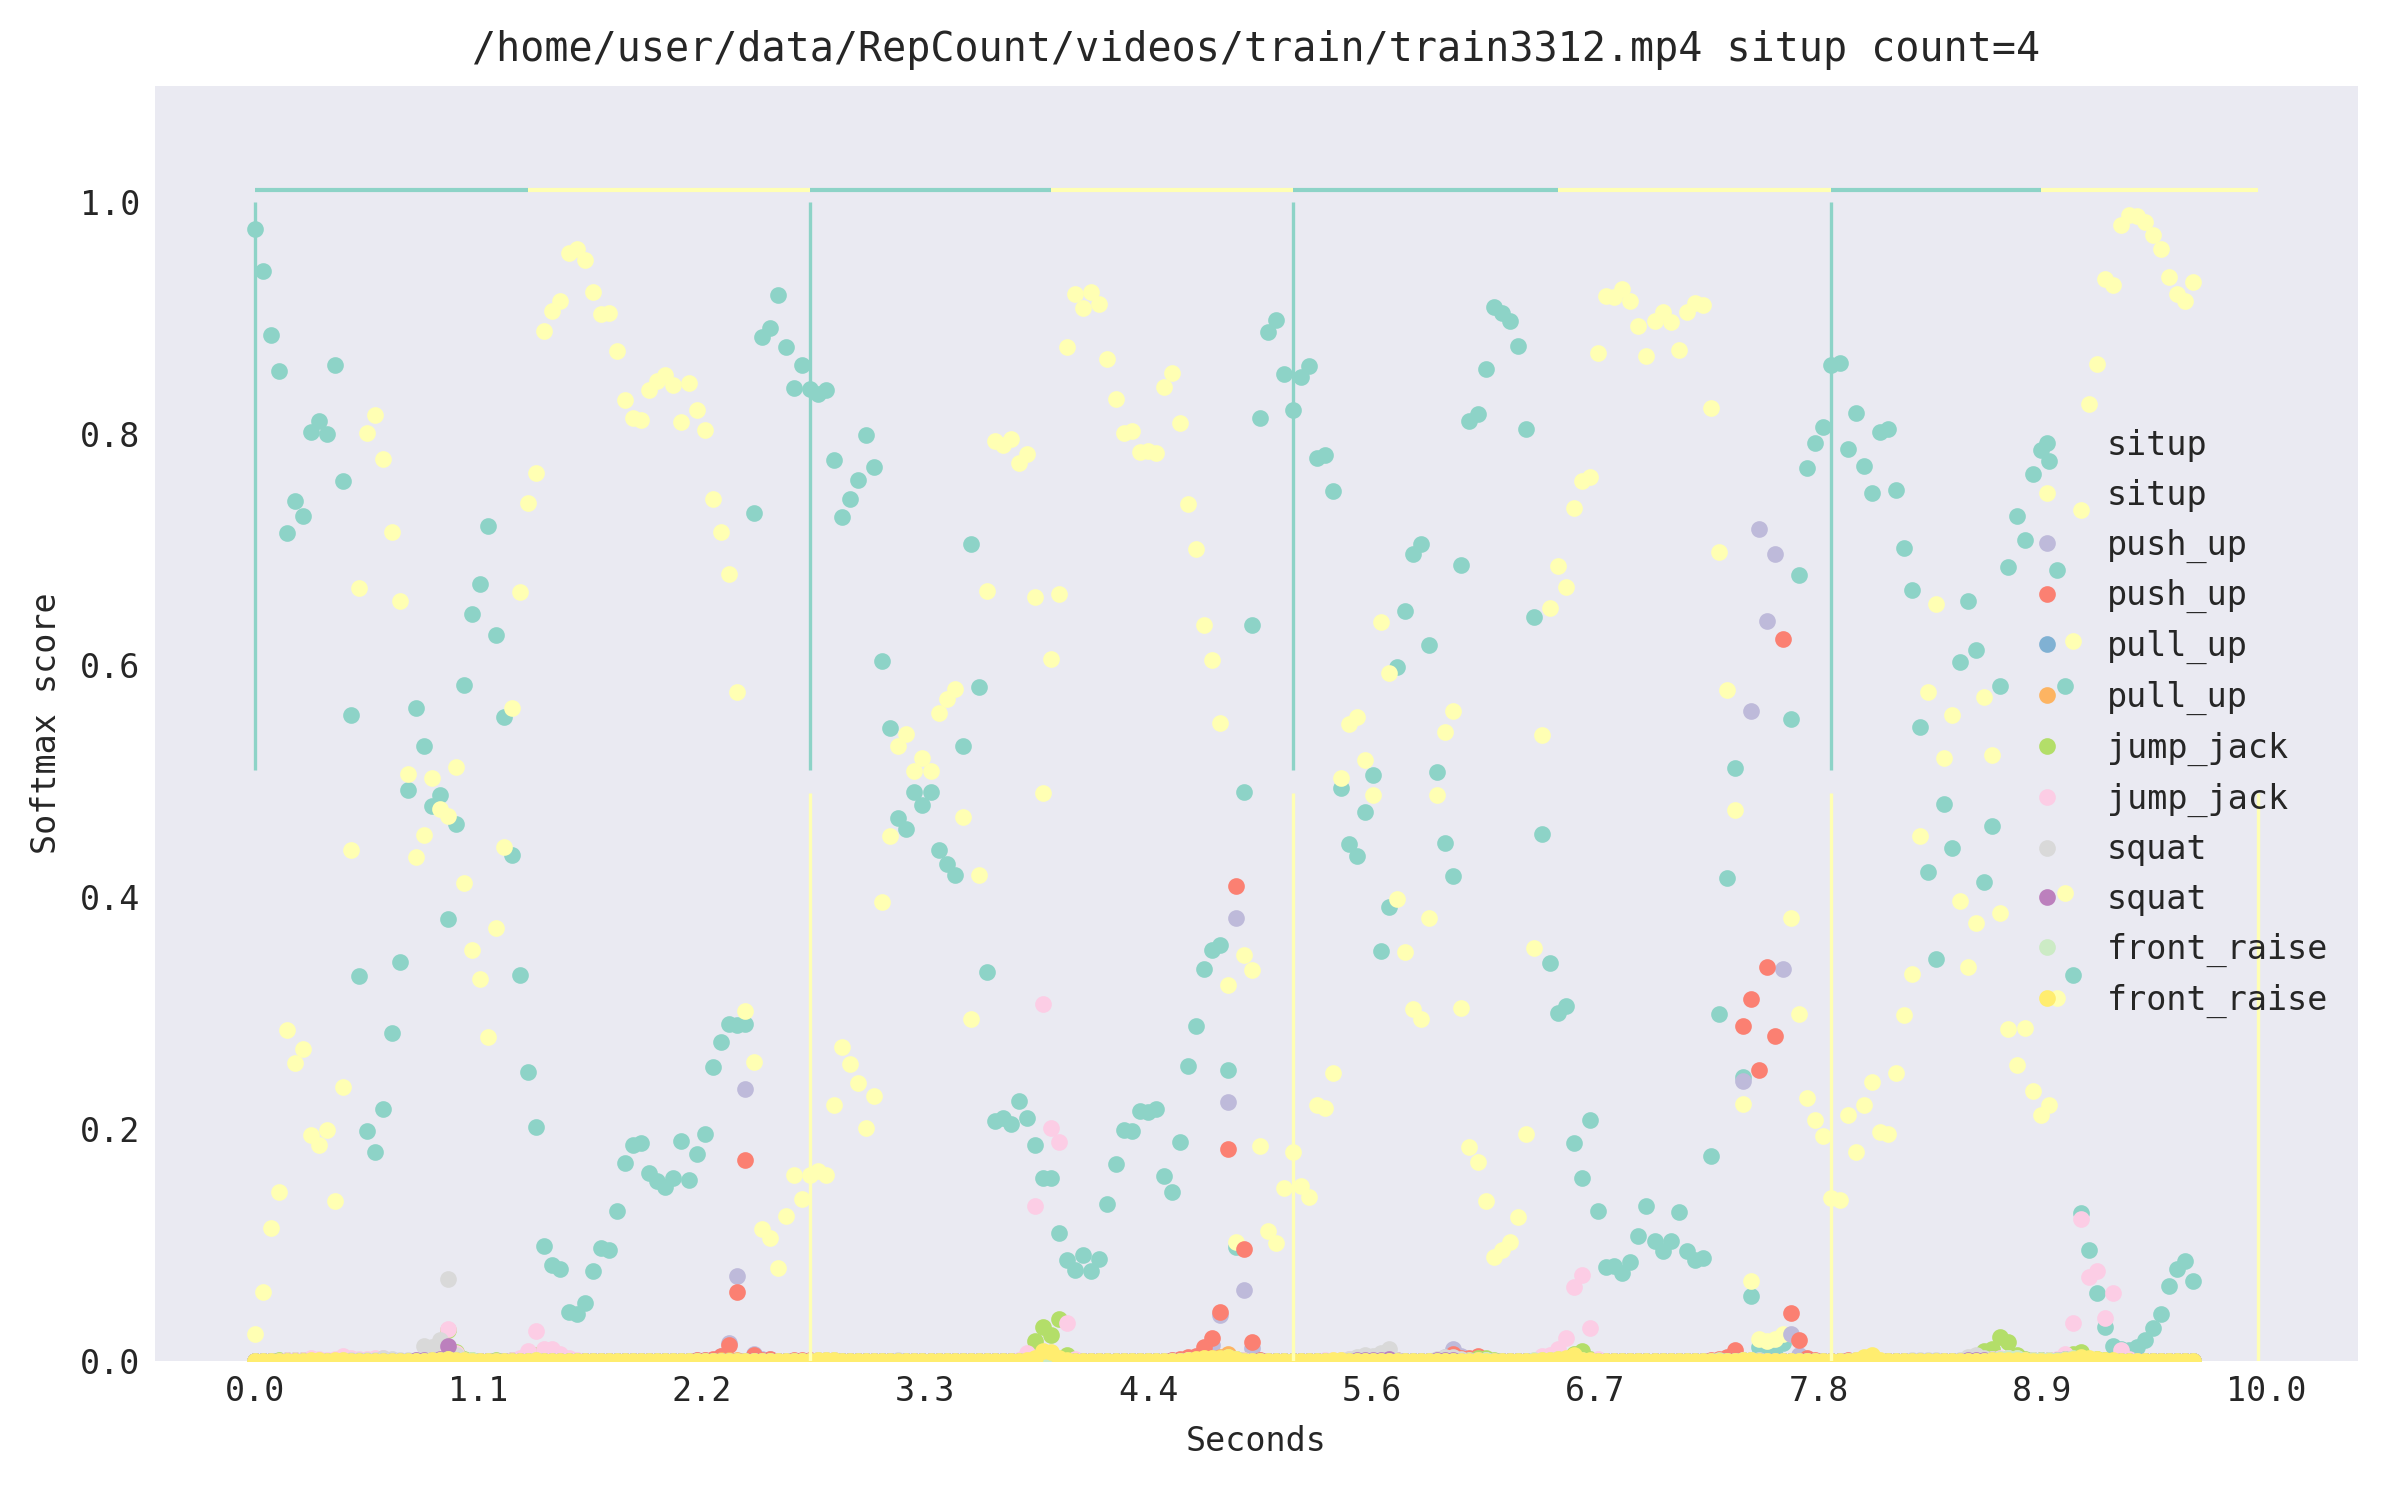

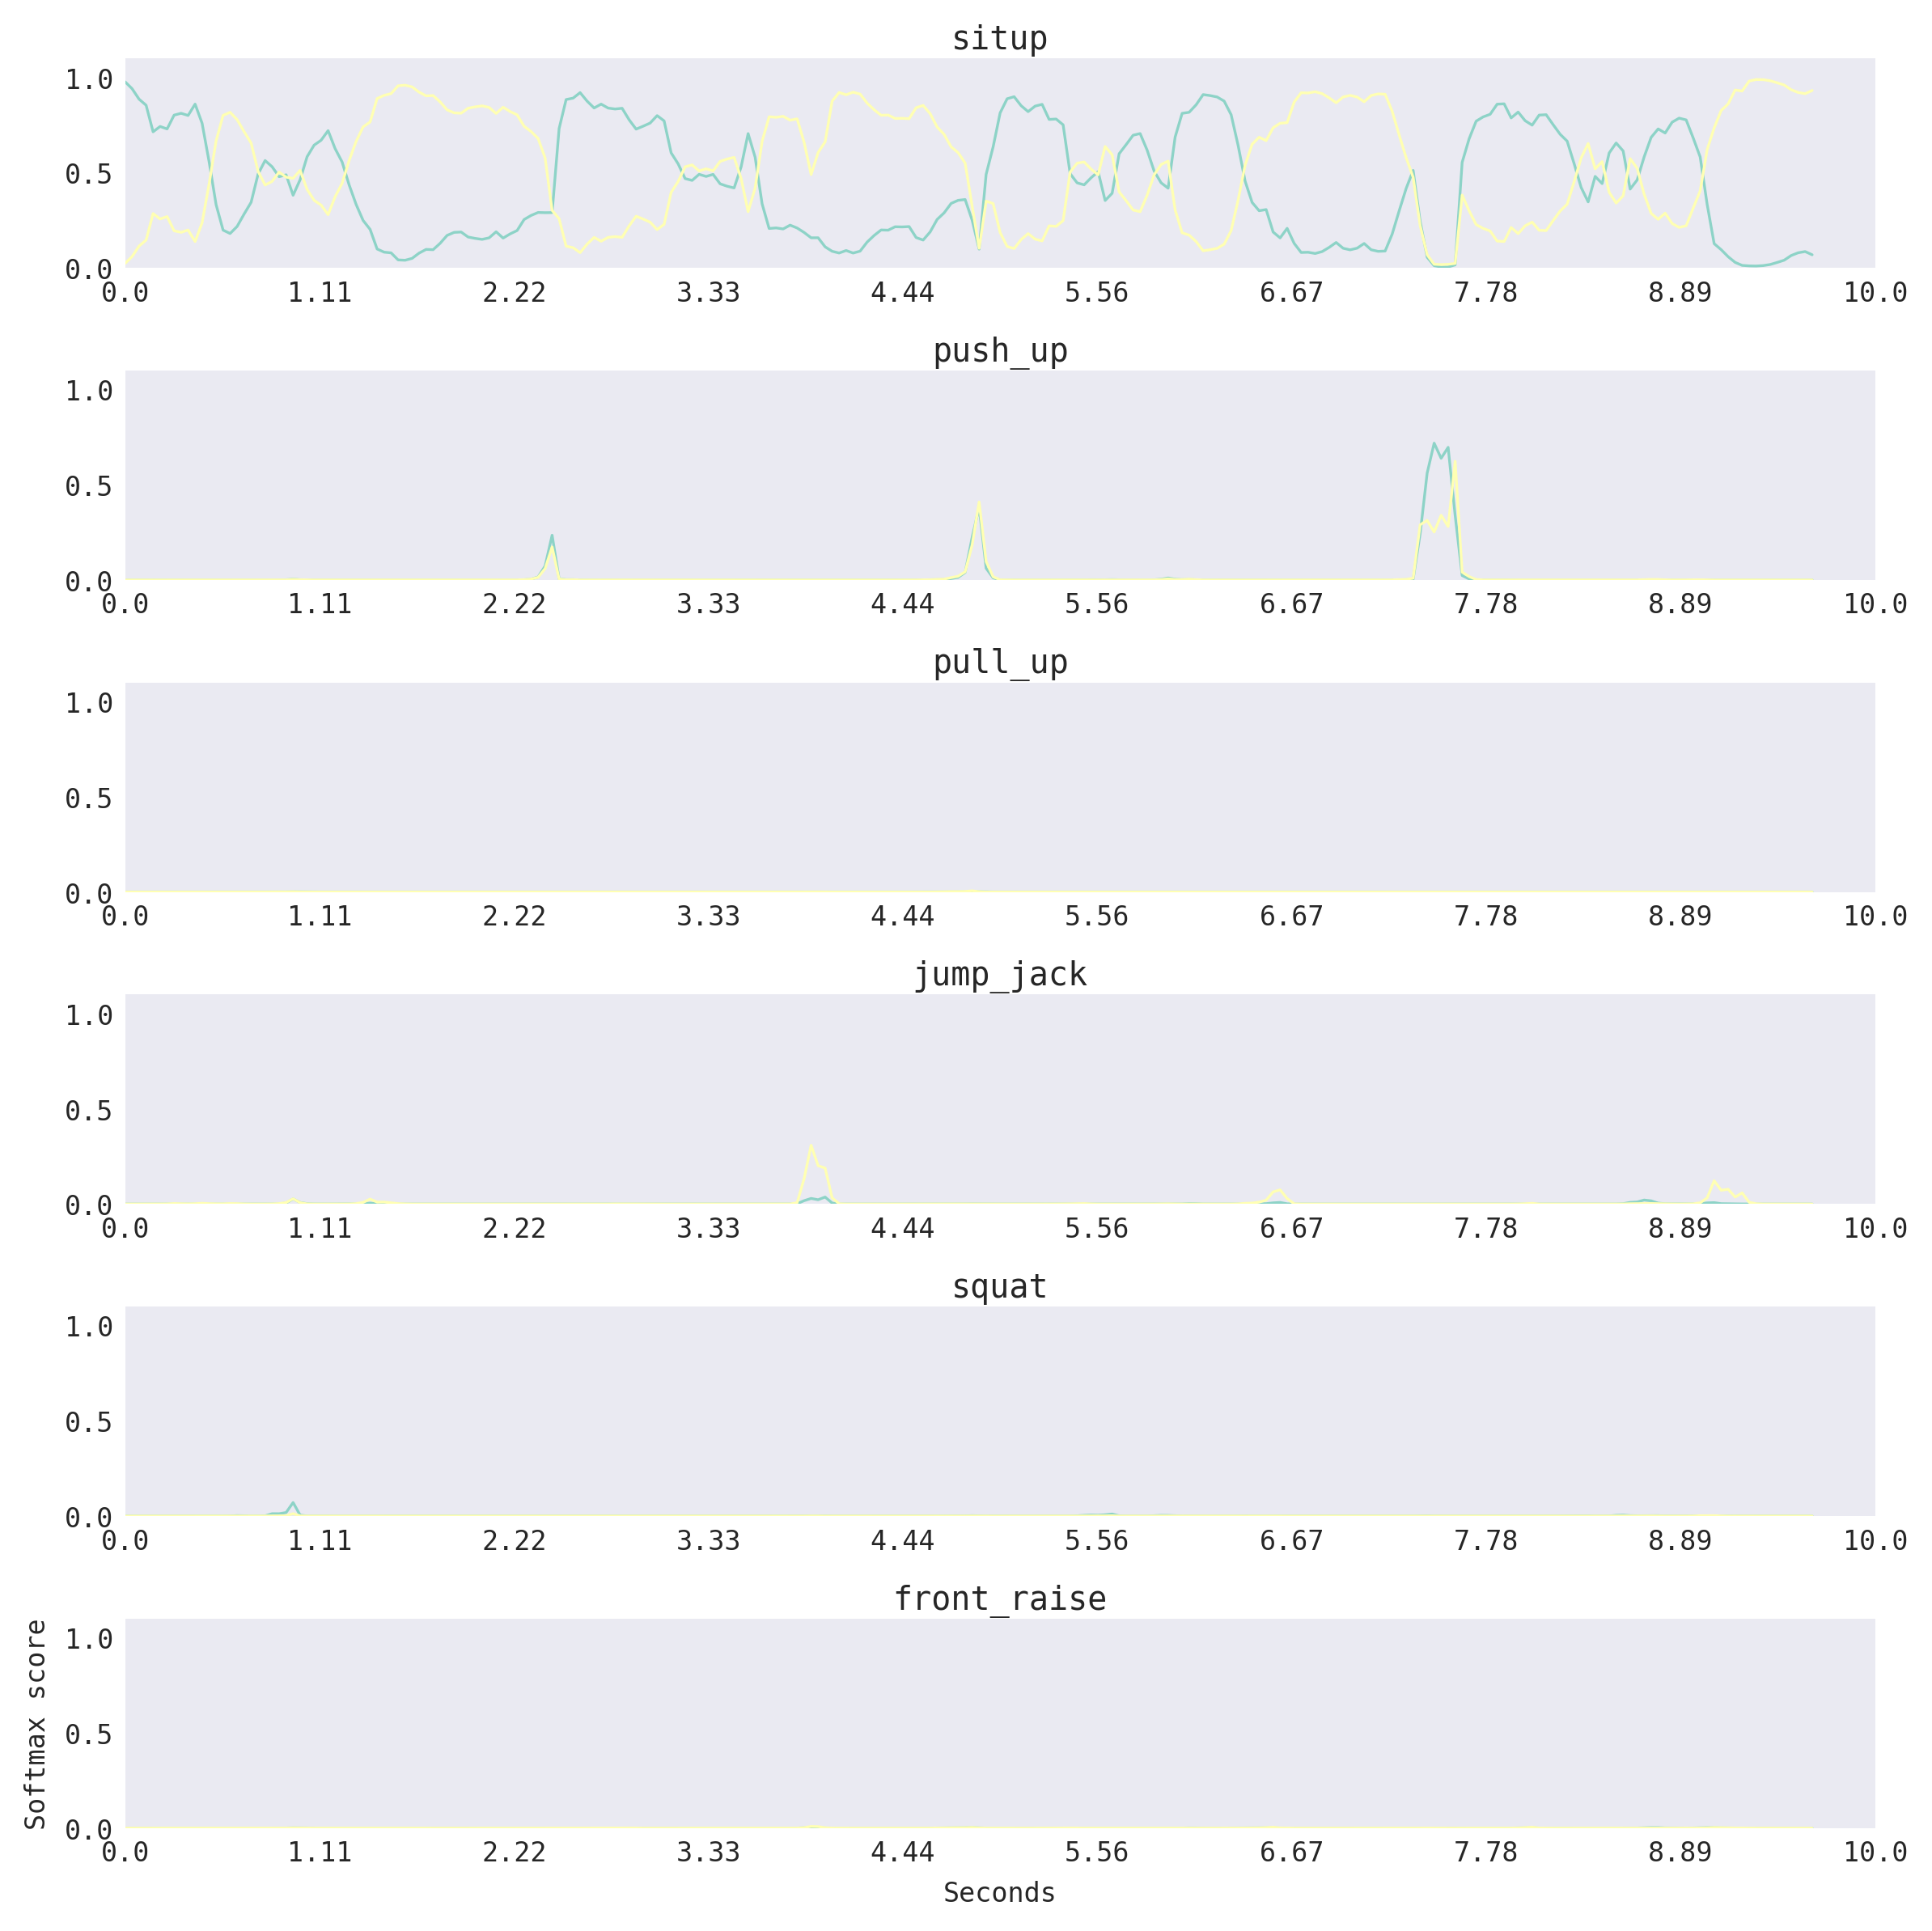

In [7]:
json_path = next(video_iter)
js = json.load(open(osj(video_save_dir, json_path)))
print(js['video_name'])
gt = np.array(js['ground_truth'])
score = js['scores']
threshold = 0.5
# print(score.values())
pred = []

for v in score.values():
    softmax_score = F.softmax(torch.Tensor(list(v.values())), dim=0)
    max_idx = torch.argmax(softmax_score)
    class_id, sc = max_idx.item(), softmax_score[max_idx].item()
    if sc >= threshold:
        pred.append(int(class_id))
    else:
        pred.append(-1)
# print(pred)
result = pred_to_count(pred[::8], stride=8, step=1)
print(result[1])
print(f'gt={len(gt)//2}, pred={result[0]}')
print('Absolute diff', abs(result[0] - len(gt) // 2))

title = f'{os.path.basename(js["video_name"])}, {js["action"]}, count={len(gt)//2}'
plot_pred(result[1], gt, js['total_frames'], js['fps'], title, step=1)
plot_all(gt, info=js, softmax=True, stride=1)
plot_per_action(info=js, softmax=True)

# write_to_video(video_path=os.path.join('/home/user/data/RepCount/videos', x.split, x.video_name),
#                output_path=f'../out/{x.video_name}',
#                reps=result[1],
#                states=pred,
#                step=8)
